In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import os
from pathlib import Path
from scipy import ndimage
from skimage import measure, morphology
import warnings
warnings.filterwarnings('ignore')

In [2]:
class CrustaceanIdentifierSystem:
    def __init__(self, img_size=(224, 224), num_classes=5):
        self.img_size = img_size
        self.num_classes = num_classes
        self.class_names = ['blue_swimming_crab','mud_crab','tiger_prawn','whiteleg_shrimp','river_crab']
        self.kmeans_model = None
        self.cnn_model = None
        self.scaler = StandardScaler()
        self.history = None

    def extract_color_features(self, image):
        """Extract color-based features from image"""
        if len(image.shape) == 3 and image.shape[2] == 3:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_rgb = image
        resized = cv2.resize(image_rgb, (64, 64))
        hist_r = cv2.calcHist([resized], [0], None, [32], [0, 256])
        hist_g = cv2.calcHist([resized], [1], None, [32], [0, 256])
        hist_b = cv2.calcHist([resized], [2], None, [32], [0, 256])

        # Calculate mean, standard, std, and skewness of color channels.
        mean_colors = np.mean(resized.reshape(-1, 3), axis=0)
        std_colors = np.std(resized.reshape(-1, 3), axis=0)
        skew_colors = np.array([
            np.mean(((resized[:, :, i] - mean_colors[i]) / std_colors[i])**3)
            for i in range(3)
        ])
        features = np.concatenate([
            hist_r.flatten(), hist_g.flatten(), hist_b.flatten(),
            mean_colors, std_colors, skew_colors
        ])
        
        return features

    def extract_shape_features(self, image):
        """Extract shape-based features from image"""
        # Convert to grayscale for shape analysis
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        # Resize for consistent feature extraction
        gray_resized = cv2.resize(gray, (128, 128))
        
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray_resized, (5, 5), 0)
        
        # Threshold to create binary image
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        shape_features = []
        
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Basic shape measurements
            area = cv2.contourArea(largest_contour)
            perimeter = cv2.arcLength(largest_contour, True)
            
            # Aspect ratio and extent
            x, y, w, h = cv2.boundingRect(largest_contour)
            aspect_ratio = float(w) / h if h != 0 else 0
            rect_area = w * h
            extent = float(area) / rect_area if rect_area != 0 else 0
            
            # Solidity (convex hull ratio)
            hull = cv2.convexHull(largest_contour)
            hull_area = cv2.contourArea(hull)
            solidity = float(area) / hull_area if hull_area != 0 else 0
            
            # Circularity
            circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter != 0 else 0
            
            # Moments for shape description
            moments = cv2.moments(largest_contour)
            if moments['m00'] != 0:
                # Centroid
                cx = int(moments['m10'] / moments['m00'])
                cy = int(moments['m01'] / moments['m00'])
                # Normalized central moments (Hu moments)
                hu_moments = cv2.HuMoments(moments).flatten()
                # Take log to make them more manageable
                hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
            else:
                hu_moments = np.zeros(7)
            
            # Equivalent diameter
            equiv_diameter = np.sqrt(4 * area / np.pi) if area > 0 else 0
            
            # Compactness
            compactness = (perimeter ** 2) / (4 * np.pi * area) if area > 0 else 0
            
            # Roundness
            roundness = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
            
            # Eccentricity (using fitted ellipse)
            if len(largest_contour) >= 5:
                ellipse = cv2.fitEllipse(largest_contour)
                major_axis = max(ellipse[1])
                minor_axis = min(ellipse[1])
                eccentricity = np.sqrt(1 - (minor_axis / major_axis) ** 2) if major_axis > 0 else 0
            else:
                eccentricity = 0
            
            # Combine all shape features
            shape_features = [
                area / 10000,  # Normalized area
                perimeter / 1000,  # Normalized perimeter
                aspect_ratio,
                extent,
                solidity,
                circularity,
                equiv_diameter / 100,  # Normalized equivalent diameter
                compactness,
                roundness,
                eccentricity,
                *hu_moments  # 7 Hu moments
            ]
            
        else:
            # If no contours found, return zero features
            shape_features = [0] * 17  # 10 basic features + 7 Hu moments
        
        return np.array(shape_features)

    def extract_texture_features(self, image):
        """Extract texture-based features using Local Binary Pattern (LBP)"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        gray_resized = cv2.resize(gray, (64, 64))
        
        # Simple LBP implementation
        def local_binary_pattern(img, radius=1, neighbors=8):
            h, w = img.shape
            lbp = np.zeros((h, w), dtype=np.uint8)
            
            for i in range(radius, h - radius):
                for j in range(radius, w - radius):
                    center = img[i, j]
                    pattern = 0
                    for k in range(neighbors):
                        angle = 2 * np.pi * k / neighbors
                        x = int(i + radius * np.cos(angle))
                        y = int(j + radius * np.sin(angle))
                        if 0 <= x < h and 0 <= y < w:
                            if img[x, y] >= center:
                                pattern |= (1 << k)
                    lbp[i, j] = pattern
            return lbp
        
        lbp = local_binary_pattern(gray_resized)
        
        # Calculate histogram of LBP
        hist, _ = np.histogram(lbp.ravel(), bins=32, range=(0, 256))
        hist = hist.astype(float)
        hist /= (hist.sum() + 1e-10)  # Normalize
        
        # Additional texture features
        # Contrast, homogeneity, energy
        glcm_features = []
        
        # Simple contrast measure
        contrast = np.var(gray_resized)
        
        # Homogeneity (inverse difference moment)
        homogeneity = np.mean(gray_resized) / (np.std(gray_resized) + 1e-10)
        
        # Energy (uniformity)
        energy = np.sum(hist ** 2)
        
        texture_features = np.concatenate([
            hist,  # LBP histogram (32 features)
            [contrast / 1000, homogeneity / 100, energy]  # Additional features (3 features)
        ])
        
        return texture_features

    def extract_combined_features(self, image):
        """Extract combined color, shape, and texture features"""
        color_features = self.extract_color_features(image)
        shape_features = self.extract_shape_features(image)
        texture_features = self.extract_texture_features(image)
        
        # Combine all features
        combined_features = np.concatenate([
            color_features,
            shape_features,
            texture_features
        ])
        
        return combined_features

    def load_and_preprocess_data(self, data_dir):
        images = []
        labels = []
        features = []
        data_path = Path(data_dir)
        
        print("Extracting color, shape, and texture features...")
        
        for class_idx, class_name in enumerate(self.class_names):
            class_path = data_path / class_name
            if not class_path.exists():
                print(f"Warning: Directory {class_path} not found")
                continue
            
            class_images = list(class_path.glob('*.jpg'))
            print(f"Processing {len(class_images)} images from {class_name}")
            
            for img_file in class_images:
                try:
                    img = cv2.imread(str(img_file))
                    if img is None:
                        continue
                    
                    img_resized = cv2.resize(img, self.img_size)
                    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                    
                    # Extract combined features
                    combined_features = self.extract_combined_features(img)
                    
                    images.append(img_rgb / 255.0)
                    labels.append(class_idx)
                    features.append(combined_features)
                    
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    continue
        
        print(f"Feature vector size: {len(features[0]) if features else 0}")
        return np.array(images), np.array(labels), np.array(features)

    def apply_kmeans_clustering(self, features, n_clusters=8):
        print("Applying K-Means clustering for feature extraction...")
        features_scaled = self.scaler.fit_transform(features)
        silhouette_scores = []
        cluster_range = range(4, 15)
        
        for n in cluster_range:
            kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(features_scaled)
            silhouette_avg = silhouette_score(features_scaled, cluster_labels)
            silhouette_scores.append(silhouette_avg)
        
        optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
        print(f"Optimal number of clusters: {optimal_clusters}")
        
        self.kmeans_model = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
        cluster_labels = self.kmeans_model.fit_predict(features_scaled)
        
        return cluster_labels

    def create_vgg16_model_dual_input(self, cluster_input_dim):
        """Create a VGG16-based model that accepts both image and cluster input"""
        # Image input
        image_input = layers.Input(shape=(*self.img_size, 3), name="image_input")

        # VGG16 base model
        vgg16_base = VGG16(
            weights='imagenet',
            include_top=False,
            input_tensor=image_input,
            input_shape=(*self.img_size, 3)
        )
        
        # Freeze the first few layers of VGG16 for transfer learning
        for layer in vgg16_base.layers[:-4]:  # Freeze all but last 4 layers
            layer.trainable = False
        
        # Get VGG16 features
        vgg16_features = vgg16_base.output
        
        # === Feature extraction from VGG16 ===
        x = layers.GlobalAveragePooling2D()(vgg16_features)
        x = layers.BatchNormalization()(x)   # normalize before dense
        x = layers.Dropout(0.4)(x)           # slightly less dropout than 0.5

        # === Cluster input (shape + texture features) ===
        cluster_input = layers.Input(shape=(cluster_input_dim,), name="cluster_input")
        c = layers.BatchNormalization()(cluster_input)  # normalize cluster features
        c = layers.Dropout(0.2)(c)

        # === Combine CNN + cluster features ===
        combined = layers.Concatenate()([x, c])

        # === Fully connected layers ===
        x = layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation=None)(combined)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.5)(x)

        x = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation=None)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.4)(x)

        x = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation=None)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.3)(x)


        output = layers.Dense(self.num_classes, activation='softmax', name='predictions')(x)

        model = models.Model(inputs=[image_input, cluster_input], outputs=output)

        return model

    def train_model(self, X, y, cluster_labels, validation_split=0.2, epochs=50, batch_size=32):
        """Train VGG16-based model using both image and cluster label input"""
        print("Training VGG16-based dual-input model with enhanced features...")

        # Convert cluster labels to categorical
        cluster_features = tf.keras.utils.to_categorical(cluster_labels)

        # Convert labels to categorical
        y_cat = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)

        # Train-test split
        (X_train, X_val,
         y_train, y_val,
         cluster_train, cluster_val) = train_test_split(
            X, y_cat, cluster_features,
            test_size=validation_split, random_state=42, stratify=y
        )

        # Create VGG16-based dual-input model
        self.cnn_model = self.create_vgg16_model_dual_input(cluster_input_dim=cluster_features.shape[1])
        
        # Use a lower learning rate for transfer learning
        self.cnn_model.compile(
            optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.cnn_model.summary()

        # Data augmentation - less aggressive for transfer learning
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            shear_range=0.1,
            fill_mode='nearest'
        )

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-8),
            ModelCheckpoint('best_vgg16_crustacean_model.h5', monitor='val_accuracy', save_best_only=True)
        ]
        
        # Custom generator for dual-input
        def dual_input_generator(X, clusters, y, batch_size):
            gen = datagen.flow(X, y, batch_size=batch_size, seed=42)
            i = 0
            while True:
                X_batch, y_batch = next(gen)
                cluster_batch = clusters[i:i+len(X_batch)]
                i = (i + len(X_batch)) % len(X)
                yield {"image_input": X_batch, "cluster_input": cluster_batch}, y_batch

        steps_per_epoch = len(X_train) // batch_size

        # Training in two phases for better transfer learning
        print("Phase 1: Training with frozen VGG16 base...")
        self.history = self.cnn_model.fit(
            dual_input_generator(X_train, cluster_train, y_train, batch_size),
            steps_per_epoch=steps_per_epoch,
            validation_data=({"image_input": X_val, "cluster_input": cluster_val}, y_val),
            epochs=epochs//2,  # First half of epochs
            callbacks=callbacks,
            verbose=1
        )
        
        # Fine-tuning phase: unfreeze more layers
        print("Phase 2: Fine-tuning with unfrozen layers...")
        for layer in self.cnn_model.layers:
            if hasattr(layer, 'layers'):  # This is the VGG16 base
                for sublayer in layer.layers[-8:]:  # Unfreeze last 8 layers
                    sublayer.trainable = True
        
        # Recompile with even lower learning rate for fine-tuning
        self.cnn_model.compile(
            optimizer=optimizers.Adam(learning_rate=0.00001),  # Even lower learning rate
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Continue training for fine-tuning
        history2 = self.cnn_model.fit(
            dual_input_generator(X_train, cluster_train, y_train, batch_size),
            steps_per_epoch=steps_per_epoch,
            validation_data=({"image_input": X_val, "cluster_input": cluster_val}, y_val),
            epochs=epochs//2,  # Second half of epochs
            callbacks=callbacks,
            verbose=1
        )
        
        # Combine histories
        for key in self.history.history.keys():
            self.history.history[key].extend(history2.history[key])

        return self.history

    def evaluate_model(self, X_test, y_test, cluster_labels):
        """Evaluate VGG16-based dual-input model"""
        if self.cnn_model is None:
            print("Model not trained yet!")
            return
        
        cluster_input = tf.keras.utils.to_categorical(cluster_labels)
        y_cat = tf.keras.utils.to_categorical(y_test, num_classes=self.num_classes)

        # Predict
        y_pred = self.cnn_model.predict({"image_input": X_test, "cluster_input": cluster_input})
        y_pred_classes = np.argmax(y_pred, axis=1)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_classes, target_names=self.class_names))
        
        cm = confusion_matrix(y_test, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix - VGG16 Model')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        return y_pred_classes

    def predict_single_image(self, image_path):
        """Predict single image with VGG16-based model"""
        if self.cnn_model is None or self.kmeans_model is None:
            print("Model or KMeans not available.")
            return None
        
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image: {image_path}")
            return None
        
        img_resized = cv2.resize(img, self.img_size)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_normalized = img_rgb / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)

        # Extract combined features for clustering
        combined_features = self.extract_combined_features(img)
        features_scaled = self.scaler.transform([combined_features])
        cluster_label = self.kmeans_model.predict(features_scaled)[0]
        cluster_input = tf.keras.utils.to_categorical([cluster_label],
                                                      num_classes=self.kmeans_model.n_clusters)
        
        # Predict
        prediction = self.cnn_model.predict({"image_input": img_batch, "cluster_input": cluster_input})
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        
        return predicted_class, confidence

In [5]:
# Usage example
crustacean_system = CrustaceanIdentifierSystem()

# Update this path to your real dataset location
data_dir = r"D:\Downloads\compiled\dataset"

print("Loading and preprocessing data with enhanced features...")
images, labels, features = crustacean_system.load_and_preprocess_data(data_dir)
print(f"Loaded {len(images)} images")

# KMeans clustering with enhanced features
cluster_labels = crustacean_system.apply_kmeans_clustering(features)

Loading and preprocessing data with enhanced features...
Extracting color, shape, and texture features...
Processing 1200 images from blue_swimming_crab
Processing 1200 images from mud_crab
Processing 1200 images from tiger_prawn
Processing 1200 images from whiteleg_shrimp
Processing 1200 images from river_crab
Feature vector size: 157
Loaded 6000 images
Applying K-Means clustering for feature extraction...
Optimal number of clusters: 7


Training VGG16-based dual-input model with enhanced features...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                              

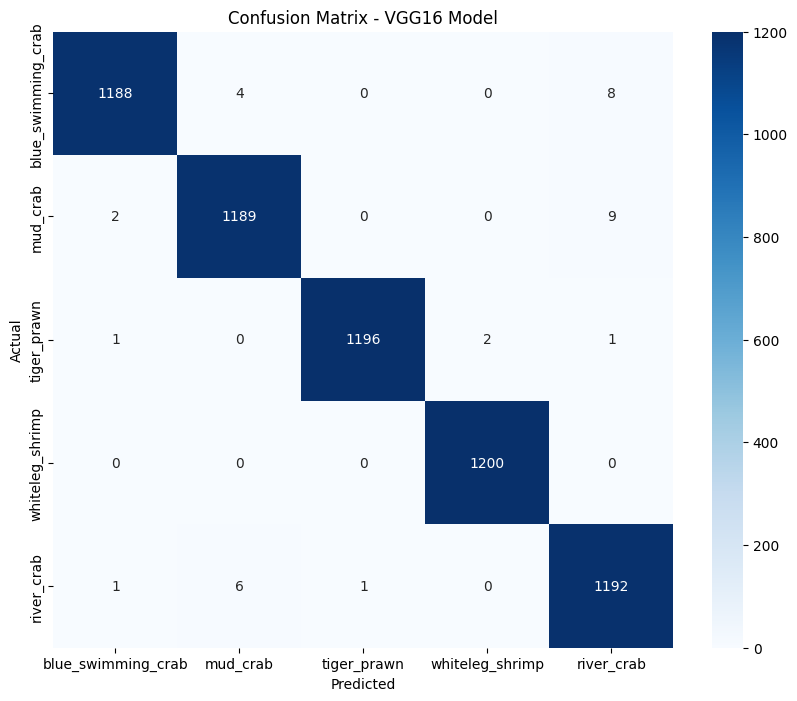

VGG16-based model training completed!


In [6]:
# Train VGG16-based model
history = crustacean_system.train_model(images, labels, cluster_labels, epochs=50, batch_size=32)

# Evaluate model
crustacean_system.evaluate_model(images, labels, cluster_labels)

# Save model
crustacean_system.cnn_model.save("vgg16_crustacean_identifier_model.h5")

print("VGG16-based model training completed!")

In [9]:
# Save files (CNN, KMeans, Scaler)
from tensorflow.keras.models import load_model
import joblib

# Save CNN model
cnn_model_path = "crustacean_CNN__VGG16_model.keras"
if crustacean_system.cnn_model:
    crustacean_system.cnn_model.save(cnn_model_path)
    print(f"✅ CNN model saved to {cnn_model_path}")
else:
    print("❌ CNN model not found. Train it first.")

# Save KMeans
kmeans_model_path = "kmeans_CNN_VGG16_model.pkl"
if crustacean_system.kmeans_model:
    joblib.dump(crustacean_system.kmeans_model, kmeans_model_path)
    print(f"✅ KMeans model saved to {kmeans_model_path}")
else:
    print("❌ KMeans model not found. Run apply_kmeans_clustering() first.")

# Save StandardScaler
scaler_path = "scaler_CNN_VGG16.pkl"
if crustacean_system.scaler:
    joblib.dump(crustacean_system.scaler, scaler_path)
    print(f"✅ Scaler saved to {scaler_path}")
else:
    print("❌ Scaler not found.")


✅ CNN model saved to crustacean_CNN__VGG16_model.keras
✅ KMeans model saved to kmeans_CNN_VGG16_model.pkl
✅ Scaler saved to scaler_CNN_VGG16.pkl
